In [2]:
# import libraries
import numpy as np
from torch import cuda
import os
from src.data.dataset_handler import load_images_from_zip
from src.data.dataset_handler import get_train_val_test_dataset_split
from src.data.analysis import show_sample_data
from src.model.model import ModelDef
from torchinfo import summary
from numpy import save as np_save
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from src.training.lion import Lion
from src.training.utils import Checkpoint
from src.data.dataloaders import get_dataloader
from src.training.training import train
from src.training.validation import validate
from src.prediction.predict import predict
import random
import cv2
import torch


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# setting up
seed = 42
image_shape = (3840, 2160)
resized_image_shape = (512, 512)
root_directory = '.'

In [5]:
# use cuda if available
DEVICE = None
if cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [6]:
# set random seed
def set_random_seed(value = 42):
    random.seed(value)
    np.random.seed(value)
    cv2.setRNGSeed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [7]:
# load images and masks
images = load_images_from_zip(os.path.join(root_directory, 'data', 'Images.zip'),
                              are_masks=False,
                              resize_shape=resized_image_shape)

masks = load_images_from_zip(os.path.join(root_directory, 'data', 'Masks.zip'),
                             are_masks=True,
                             resize_shape=resized_image_shape)

100%|██████████| 2003/2003 [00:17<00:00, 116.59it/s]


In [8]:
# check if the number of images corresponds to the number of masks
assert len(images) == len(masks), \
    'The number of images does not correspond to the number of masks.'

[autoreload of src.training.validation failed: Traceback (most recent call last):
  File "/home/kiran/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/kiran/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/kiran/final project/backup/src/training/validation.py", line 47
    predictions = image_size_changepredictions, new_size=resize_evaluatio

In [9]:
# split the dataset into training, validation and test sets
(X_train, y_train), (X_val, y_val), (X_test, y_test) = get_train_val_test_dataset_split(images, masks, seed=seed)

In [10]:
# model definition
model = ModelDef(resized_image_shape, DEVICE)

In [11]:
# set batch size
batch_size_training = 2
batch_size_evaluation = 2

In [12]:
# model summary
summary(model, input_size=(batch_size_training, 3, *resized_image_shape))

Layer (type:depth-idx)                                  Output Shape              Param #
ModelDef                                                [2, 2, 512, 512]          --
├─Encoder: 1-1                                          [2, 16, 256, 256]         --
│    └─DCNN: 2-1                                        [2, 16, 256, 256]         --
│    │    └─Sequential: 3-1                             [2, 16, 256, 256]         464
│    │    └─Sequential: 3-2                             [2, 16, 256, 256]         752
│    │    └─Sequential: 3-3                             [2, 24, 128, 128]         7,880
│    │    └─Sequential: 3-4                             [2, 40, 64, 64]           56,168
│    │    └─Sequential: 3-5                             [2, 160, 32, 32]          2,388,040
│    └─ASPP: 2-2                                        [2, 256, 32, 32]          --
│    │    └─Sequential: 3-6                             [2, 256, 32, 32]          41,472
│    │    └─Sequential: 3-7             

In [13]:
train_mean = np.mean(X_train, axis=(-4, -3, -2)) # mean over the channels, height, and width
train_std = np.std(X_train, axis=(-4, -3, -2)) 

train_mean_std_file_path = os.path.join(root_directory, 'model', 'mean-std.npy')
os.makedirs(os.path.dirname(train_mean_std_file_path), exist_ok=True)
np_save(train_mean_std_file_path, (train_mean, train_std))

In [15]:
# data loaders
train_loader = get_dataloader(
    X_train, y_train, train_mean, train_std, batch_size=batch_size_training,
    shuffle=True, apply_augmentation=True)

val_loader = get_dataloader(
    X_val, y_val, train_mean, train_std, batch_size=batch_size_evaluation,
    shuffle=False, apply_augmentation=False)

test_loader = get_dataloader(
    X_test, y_test, train_mean, train_std, batch_size=batch_size_evaluation,
    shuffle=False, apply_augmentation=False)

In [16]:
# lion optimizer
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-5)

# learning rate schedulers
step_lr_scheduler = StepLR(optimizer, gamma=.94, step_size=1)
plateau_lr_scheduler = ReduceLROnPlateau(
    optimizer, factor=.98, patience=300, threshold=1e-6)
lr_schedulers=[step_lr_scheduler, plateau_lr_scheduler]

In [17]:
# number of epochs and validation steps
EPOCHS = 1
VAL_STEP = 200

# set checkpoint
checkpoint = Checkpoint(os.path.join(root_directory, 'model', 'checkpoints.pth'))

In [18]:
# store the history of the training
history = train(model, optimizer, train_loader, val_loader, EPOCHS, VAL_STEP,
                DEVICE, checkpoint, lr_schedulers, reload_best_weights=True)

Epoch 1/1


In [19]:
checkpoint.load_best_weights(model)
model.eval();

In [20]:
# validation results
val_loss, val_mpa, val_miou, val_fps = validate(
    model, val_loader, DEVICE, resize_evaluation_shape=image_shape)

In [21]:
# test results
test_loss, test_mpa, test_miou, test_fps = validate(
    model, test_loader, DEVICE, resize_evaluation_shape=image_shape)

In [22]:
# get predictions to original size
y_pred = predict(model, test_loader, DEVICE)

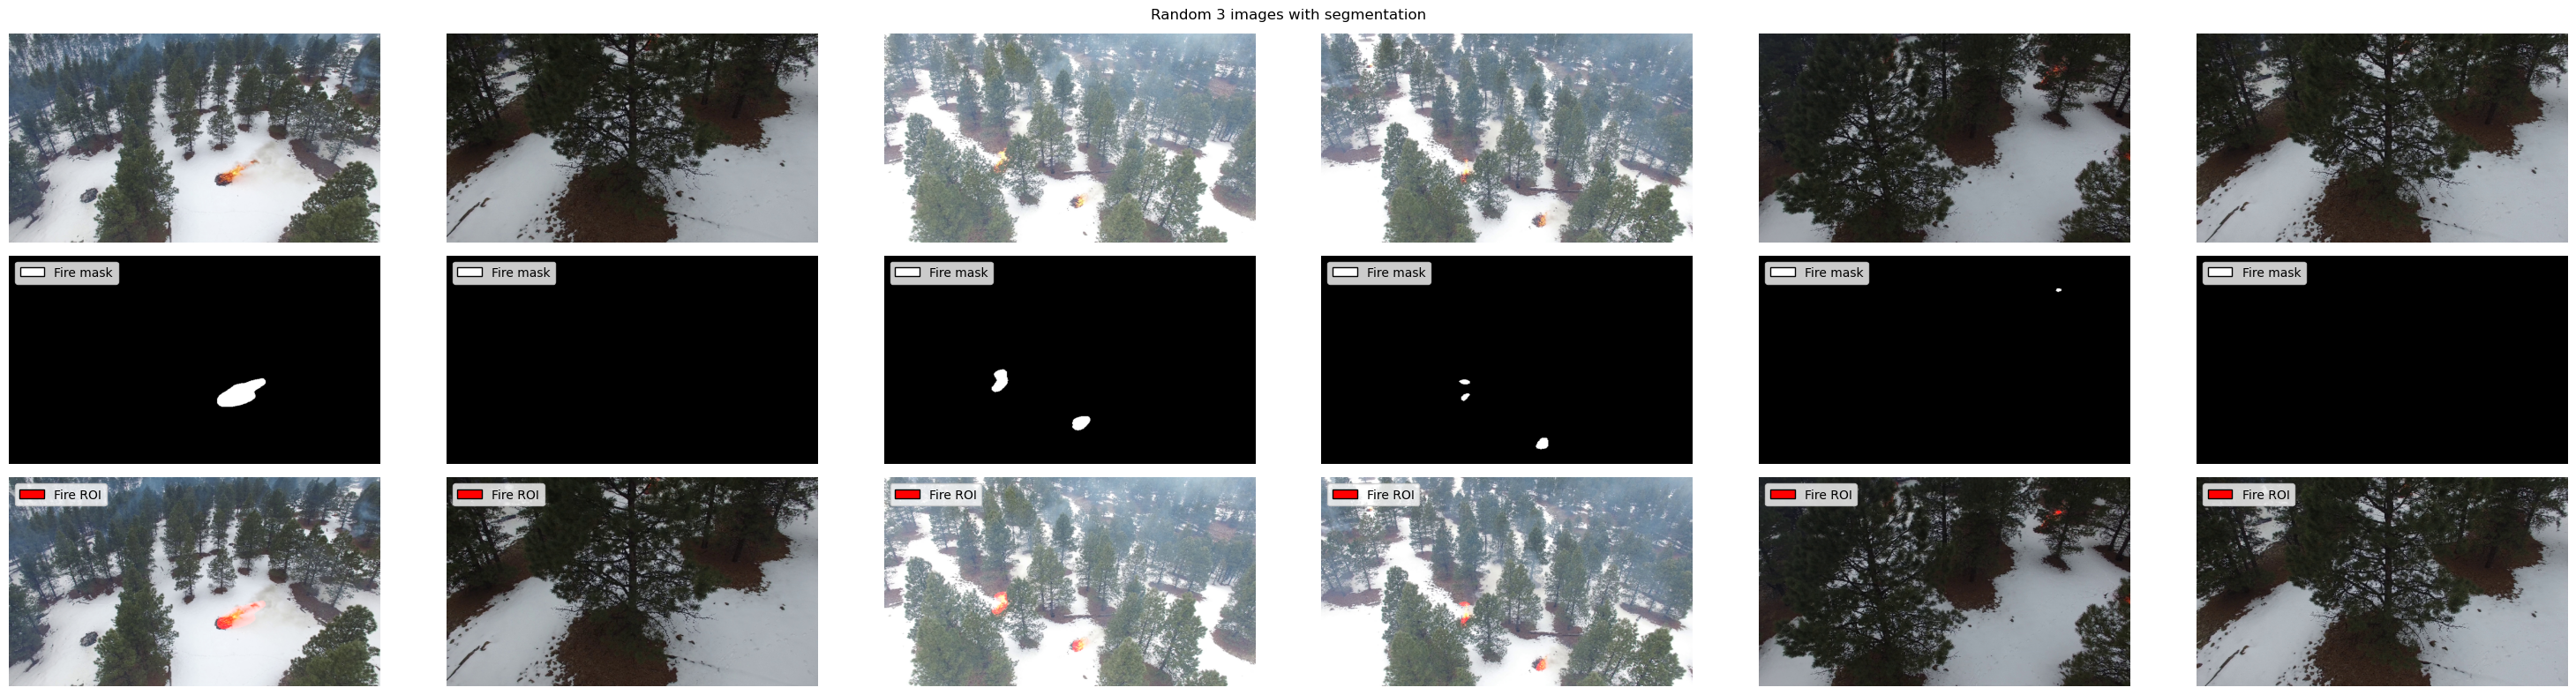

In [23]:
# show output with predicted mask and highlighted segmentation
show_sample_data(
    X_test, y_pred,
    title='Random 3 images '
    'with segmentation',
    resize_shape=image_shape)